# About

**Author** : htrf88<br>
**Description** : Bias in AI coursework Task 3 implementation

> **Note**
> Please run notebook cells in order to recreate the output

# Setup

## Common imports

In [ ]:
from IPython.display import display
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
pd.options.display.float_format = '{:,.3f}'.format

## Train, test, evaluation setup

In [ ]:
!pip install shap

In [ ]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import RandomForestClassifier
import shap

In [ ]:
def encode_and_scale(df):
    disc_ft = ['workclass', 'occupation', 'relationship']
    cont_ft = ['age', 'education_num', 'hours_per_week']
    label_mapping = {}
    le = LabelEncoder()
    for i in disc_ft:
        df[i] = le.fit_transform(df[i])
        label_mapping[i] = dict(zip(le.classes_, le.transform(le.classes_)))

    df[cont_ft] = StandardScaler().fit_transform(df[cont_ft])
    return df

In [ ]:
def train(X_train, y_train, X_test, y_test):
    clf = RandomForestClassifier(max_depth=8, random_state=42)
    cv_results = cross_validate(clf, X_test, y_test, cv=10)
    clf.fit(X_train, y_train)
    print("10 fold cross validation accuracy: %.2f%%\n" % (cv_results['test_score'].mean()*100.0))
    return clf

In [ ]:
def shap_summery(model, samples):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(samples)
    shap.summary_plot(shap_values[1], samples)

## Model bias evaluation functions

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, plot_roc_curve
from sklearn.metrics import precision_recall_curve, average_precision_score

def check_bias(model, X_test, y_test, features, exclude_cols=[]):
    # Generate the required data for evaluation
    df = X_test.copy()
    df['true'] = y_test
    if exclude_cols:
        df['pred'] = model.predict(X_test.drop(exclude_cols, axis=1))
        df['score'] = model.predict_proba(X_test.drop(exclude_cols, axis=1))[:,1]
    else:
        df['pred'] = model.predict(X_test)
        df['score'] = model.predict_proba(X_test)[:,1]
    
    bias_df = []
    for feature in features:
        # Calculate confusion matrix for privileged and unprivileged classes
        priv, unpriv = df[df[feature] == 1], df[df[feature] == 0]
        TN_p, FP_p, FN_p, TP_p = confusion_matrix(priv.true, priv.pred).ravel()
        TN_u, FP_u, FN_u, TP_u = confusion_matrix(unpriv.true, unpriv.pred).ravel()
        # Calculate metrics of bias
        rate_pos_outcome_p = (TP_p + FP_p)/(TN_p + FP_p + FN_p + TP_p)  # rate of +ve outcome privileged
        rate_pos_outcome_u = (TP_u + FP_u)/(TN_u + FP_u + FN_u + TP_u)  # rate of +ve outcome unprivileged
        # Statistical piraty : diff of the rate of +ve outcomes of unprivileged and privileged groups
        stat_piraty = rate_pos_outcome_u - rate_pos_outcome_p
        # Disparate Impact : ratio of prob of +ve outcomes between the unprivileged and privileged group
        disp_impact = rate_pos_outcome_u / rate_pos_outcome_p

        res = pd.DataFrame(index=['Statistical Parity Diff', 'Disparate Impact'])
        res['value'] = [stat_piraty, disp_impact]
        res['biased'] = [~i for i in [-0.1 <= stat_piraty <= 0.1, 0.8 <= disp_impact <= 1.25 ]]
        bias_df.append(res)
    
    print(" "*25 + ''.join([i.ljust(15) for i in features]))
    print(pd.concat(bias_df, axis=1))
    
    # Plot ROC curve
    plt.figure(figsize=(12, 5))
    plt.subplots_adjust(0.125, 0.1, 0.9, 0.9, 0.3, 0.5)
    plt.subplot(1,2,1)
    for feature in features:
        for i in df[feature].unique():
            y_true, y_score = df[df[feature] == i].true, df[df[feature] == i].score
            fpr, tpr, _ = roc_curve(y_true, y_score)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2,
                    label=f'{feature} {"favoured" if i == 1 else "deprived"} (AUC = %0.2f)'%roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
        
    # Plot precision-recall curve
    plt.subplot(1,2,2)
    legend = []
    for feature in features:
        for i in df[feature].unique():
            y_true, y_score = df[df[feature] == i].true, df[df[feature] == i].score
            precision, recall, _ = precision_recall_curve(y_true, y_score)
            avg_prec = average_precision_score(y_true, y_score)
            legend.append(f'{feature} {"favoured" if i == 1 else "deprived"} (AP = %0.2f)' % avg_prec)
            plt.step(recall, precision, where='post')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.01])
    plt.xlim([0.0, 1.0])
    plt.title('Precision Recall Curve')
    plt.legend(legend)
    plt.grid(True)
    plt.show()

# Task 3.2 - Data Analysis

## 3.2.1 Load dataset

The original dataset (Adult Census Income Dataset) can be found at [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/adult)

In [ ]:
FEATURES = ["age", "workclass", "fnlwgt", "education", "education_num", "marital_status", "occupation", 
            "relationship", "race", "sex", "capital_gain", "capital_loss", "hours_per_week", "native_country", "salary"]

CONTINUOUS = ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']
DISCRETE = ["workclass", "education", "marital_status", "occupation", "relationship", "race", "sex", "native_country", 
            "salary"]

data = pd.read_csv("https://raw.githubusercontent.com/atharvat80/datasets/main/adult-all.csv", 
                   na_values='?', names=FEATURES)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       46043 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education_num   48842 non-null  int64 
 5   marital_status  48842 non-null  object
 6   occupation      46033 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital_gain    48842 non-null  int64 
 11  capital_loss    48842 non-null  int64 
 12  hours_per_week  48842 non-null  int64 
 13  native_country  47985 non-null  object
 14  salary          48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


## 3.2.2 Inspect different demographic groups within the data

Distribution of numerical features

In [ ]:
num_info = data[CONTINUOUS].describe().transpose()
num_info.drop(columns=['count'], axis=0, inplace=True)
num_info['var'] = [data[i].var() for i in CONTINUOUS]
num_info.transpose()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
mean,38.644,"189,664.135",10.078,"1,079.068",87.502,40.422
std,13.711,"105,604.025",2.571,"7,452.019",403.005,12.391
min,17.000,"12,285.000",1.000,0.000,0.000,1.000
25%,28.000,"117,550.500",9.000,0.000,0.000,40.000
50%,37.000,"178,144.500",10.000,0.000,0.000,40.000
75%,48.000,"237,642.000",12.000,0.000,0.000,45.000
max,90.000,"1,490,400.000",16.000,"99,999.000","4,356.000",99.000
var,187.978,"11,152,210,185.575",6.610,"55,532,588.036","162,412.669",153.548


Distribution of selective numerical features with seperated by the outcome of the target variable

In [ ]:
continuous = ['age', 'education_num', 'hours_per_week']
data[continuous+['salary']].groupby(['salary']).agg(['count', 'mean', 'std', 'var']).transpose()

salary                    <=50K       >50K
age            count 37,155.000 11,687.000
               mean      36.872     44.275
               std       14.104     10.559
               var      198.926    111.492
education_num  count 37,155.000 11,687.000
               mean       9.598     11.603
               std        2.438      2.383
               var        5.942      5.677
hours_per_week count 37,155.000 11,687.000
               mean      38.840     45.453
               std       12.357     11.091
               var      152.692    123.014

Distribution of selective numerical variables seperated by outcome of the target variable and protected class `sex`

In [ ]:
data[continuous+['salary','sex']].groupby(['sex', 'salary']).agg(['count', 'mean', 'std', 'var']).transpose()

sex                      Female                 Male          
salary                    <=50K      >50K      <=50K      >50K
age            count 14,423.000 1,769.000 22,732.000 9,918.000
               mean      36.279    42.219     37.249    44.642
               std       14.387    10.505     13.909    10.527
               var      206.999   110.352    193.448   110.818
education_num  count 14,423.000 1,769.000 22,732.000 9,918.000
               mean       9.825    11.832      9.455    11.562
               std        2.307     2.202      2.507     2.411
               var        5.322     4.849      6.283     5.814
hours_per_week count 14,423.000 1,769.000 22,732.000 9,918.000
               mean      35.876    40.679     40.721    46.304
               std       11.855    11.854     12.300    10.729
               var      140.542   140.511    151.295   115.117

Distribution of selective numerical variables seperated by outcome of the target variable and protected class `race`

In [ ]:
data[continuous+['salary','race']].groupby(['race', 'salary']).agg(['count', 'mean', 'std', 'var']).transpose()

race                 Amer-Indian-Eskimo         ...      White           
salary                            <=50K   >50K  ...      <=50K       >50K
age            count            415.000 55.000  ... 31,155.000 10,607.000
               mean              36.128 40.964  ...     36.929     44.390
               std               12.368  9.469  ...     14.303     10.621
               var              152.957 89.665  ...    204.582    112.803
education_num  count            415.000 55.000  ... 31,155.000 10,607.000
               mean               9.176 10.982  ...      9.629     11.603
               std                2.151  2.198  ...      2.433      2.373
               var                4.628  4.833  ...      5.919      5.630
hours_per_week count            415.000 55.000  ... 31,155.000 10,607.000
               mean              39.817 43.709  ...     38.995     45.552
               std               12.256  8.956  ...     12.627     11.160
               var              150.213 80.210  ...    159.446    124.545

[12 rows x 10 columns]

Analysing categorical data

In [ ]:
for i in DISCRETE[:-1]:
    print("Demographic group: ", i)
    print("3 most frequent values: " + ', '.join(data[i].value_counts()[:3].index.tolist()))
    unq = data[i].unique()
    info = pd.DataFrame(columns=["Count"], index=unq)
    info["Count"] = [data[data[i] == j].shape[0] for j in unq]
    info[">50K (%)"] = [data[(data[i] == j) & (data.salary == '>50K')].shape[0] for j in unq]
    info[">50K (%)"] = np.round(info[">50K (%)"]/info["Count"], 3)
    info = info.sort_values(by=['>50K (%)'], ascending=False)
    print("Population size and % of population earning >50K a year for this demographic as described below")
    display(info.transpose())
    print("")

Demographic group:  workclass
3 most frequent values: Private, Self-emp-not-inc, Local-gov
Population size and % of population earning >50K a year for this demographic as described below


,Self-emp-inc,Federal-gov,Local-gov,Self-emp-not-inc,State-gov,Private,Without-pay,Never-worked,NaN
Count,"1,695.000","1,432.000","3,136.000","3,862.000","1,981.000","33,906.000",21.000,10.000,0.000
>50K (%),0.553,0.392,0.296,0.279,0.268,0.218,0.095,0.000,nan



Demographic group:  education
3 most frequent values: HS-grad, Some-college, Bachelors
Population size and % of population earning >50K a year for this demographic as described below


,Prof-school,Doctorate,Masters,Bachelors,Assoc-acdm,Assoc-voc,Some-college,HS-grad,12th,7th-8th,10th,9th,5th-6th,11th,1st-4th,Preschool
Count,834.000,594.000,"2,657.000","8,025.000","1,601.000","2,061.000","10,878.000","15,784.000",657.000,955.000,"1,389.000",756.000,509.000,"1,812.000",247.000,83.000
>50K (%),0.740,0.726,0.549,0.413,0.258,0.253,0.190,0.159,0.073,0.065,0.063,0.054,0.053,0.051,0.032,0.012



Demographic group:  marital_status
3 most frequent values: Married-civ-spouse, Never-married, Divorced
Population size and % of population earning >50K a year for this demographic as described below


,Married-civ-spouse,Married-AF-spouse,Divorced,Married-spouse-absent,Widowed,Separated,Never-married
Count,"22,379.000",37.000,"6,633.000",628.000,"1,518.000","1,530.000","16,117.000"
>50K (%),0.446,0.378,0.101,0.092,0.084,0.065,0.045



Demographic group:  occupation
3 most frequent values: Prof-specialty, Craft-repair, Exec-managerial
Population size and % of population earning >50K a year for this demographic as described below


,Exec-managerial,Prof-specialty,Armed-Forces,Protective-serv,Tech-support,Sales,Craft-repair,Transport-moving,Adm-clerical,Machine-op-inspct,Farming-fishing,Handlers-cleaners,Other-service,Priv-house-serv,NaN
Count,"6,086.000","6,172.000",15.000,983.000,"1,446.000","5,504.000","6,112.000","2,355.000","5,611.000","3,022.000","1,490.000","2,072.000","4,923.000",242.000,0.000
>50K (%),0.478,0.451,0.333,0.313,0.290,0.268,0.226,0.204,0.137,0.123,0.116,0.067,0.041,0.012,nan



Demographic group:  relationship
3 most frequent values: Husband, Not-in-family, Own-child
Population size and % of population earning >50K a year for this demographic as described below


,Wife,Husband,Not-in-family,Unmarried,Other-relative,Own-child
Count,"2,331.000","19,716.000","12,583.000","5,125.000","1,506.000","7,581.000"
>50K (%),0.469,0.449,0.101,0.060,0.035,0.015



Demographic group:  race
3 most frequent values: White, Black, Asian-Pac-Islander
Population size and % of population earning >50K a year for this demographic as described below


,Asian-Pac-Islander,White,Other,Black,Amer-Indian-Eskimo
Count,"1,519.000","41,762.000",406.000,"4,685.000",470.000
>50K (%),0.269,0.254,0.123,0.121,0.117



Demographic group:  sex
3 most frequent values: Male, Female
Population size and % of population earning >50K a year for this demographic as described below


,Male,Female
Count,"32,650.000","16,192.000"
>50K (%),0.304,0.109



Demographic group:  native_country
3 most frequent values: United-States, Mexico, Philippines
Population size and % of population earning >50K a year for this demographic as described below


,France,India,Taiwan,Iran,England,Greece,Yugoslavia,Japan,Canada,Italy,Cambodia,Hungary,Ireland,China,Philippines,Germany,Hong,Cuba,United-States,Poland,Portugal,South,Thailand,Scotland,Jamaica,Ecuador,Haiti,Puerto-Rico,Honduras,Laos,Peru,Vietnam,Trinadad&Tobago,El-Salvador,Nicaragua,Mexico,Dominican-Republic,Columbia,Outlying-US(Guam-USVI-etc),Guatemala,Holand-Netherlands,NaN
Count,38.000,151.000,65.000,59.000,127.000,49.000,23.000,92.000,182.000,105.000,28.000,19.000,37.000,122.000,295.000,206.000,30.000,138.000,"43,832.000",87.000,67.000,115.000,30.000,21.000,106.000,45.000,75.000,184.000,20.000,23.000,46.000,86.000,27.000,155.000,49.000,951.000,103.000,85.000,23.000,88.000,1.000,0.000
>50K (%),0.421,0.411,0.400,0.373,0.370,0.367,0.348,0.348,0.346,0.324,0.321,0.316,0.297,0.295,0.288,0.282,0.267,0.246,0.244,0.195,0.179,0.174,0.167,0.143,0.142,0.133,0.120,0.109,0.100,0.087,0.087,0.081,0.074,0.071,0.061,0.049,0.049,0.047,0.043,0.034,0.000,nan


## Data Preparation

`NaN` values are dropped. Individual aged 80+ years working full time are also removed because it is highly unusual for someone over the age of 80 to be working full time. After that the following data transformation is applied to the dataset. 

**Attribute**|**Original value**|**Replaced with**
-----|-----|-----
**salary**|<=50K|0
 |>50K|1
**race**|Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black|0
 |White|1
**sex**|Female|0
 |Male|1
**native-country**|All non 'United States' value|0
 |United States|1
**martial-status**|Divorced','Married-spouse-absent', 'Never-married','Separated','Widowed'|0
 |'Married-AF-spouse','Married-civ-spouse'|1
**workclass**|Federal-gov, Local-gov, State-gov,|gov
 |Private|private
 |Self-emp-inc|self\_employed
 |Without-pay, Never-worked, Self-emp-not-inc|without\_pay
**occupation**|'Adm-clerical', 'Exec-managerial'|White-Collar
 |'Craft-repair', 'Farming-fishing', 'Handlers-cleaners', 'Machine-op-inspct', 'Transport-moving'|Blue-Collar
 |'Other-service', 'Priv-house-serv', 'Protective-serv', 'Tech-support'|Service
 |Prof-specialty|Professional
**capital-gain**|Zero value|0
 |Non zero value|1
**capital-loss**|Zero value|0
 |Non zero value|1

In [ ]:
# Drop nan values and the index column
data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)

# Removing individual of age over 80 years working full time because it is highly unusual
data = data[~((data['age'] >= 80) & (data['hours_per_week'] >= 20))]

# Encode the binary attribute
data['salary'] = data['salary'].map(lambda x : 1 if x == '>50K' else 0)

# replace native_country, race and sex with 1 if the value belongs to the privileged group
# and 0 in it belong to the unprivilaged group
data['native_country'] = data['native_country'].apply(lambda x: 1 if x == "United-States" else 0)
data['race'] = data['race'].apply(lambda x: 1 if x == "White" else 0) # privileged group - White
data['sex'] = data['sex'].apply(lambda x: 1 if x == "Male" else 0)    # privileged group - Male


# Encode marital-status
data['marital_status'] = data['marital_status'].replace(['Divorced','Married-spouse-absent',
                                                         'Never-married','Separated','Widowed'], 0)
data['marital_status'] = data['marital_status'].replace(['Married-AF-spouse','Married-civ-spouse'], 1)


# Simplify workclass
def workclass(x):
    if 'gov' in x:
        return 'gov'
    elif x == 'Private':
        return 'private'
    elif x == 'Self-emp-inc':
        return 'self_employed'
    else:
        return 'without_pay'

data['workclass'] = data['workclass'].apply(workclass)


# Simplify occupation
def occupation(x):
    if x in ['Adm-clerical', 'Exec-managerial']:
        return 'White-Collar'
    elif x in ['Craft-repair', 'Farming-fishing', 'Handlers-cleaners', 'Machine-op-inspct', 'Transport-moving']:
        return 'Blue-Collar'
    elif x in ['Other-service', 'Priv-house-serv', 'Protective-serv', 'Tech-support']:
        return 'Service'
    elif x == 'Prof-specialty':
        return 'Professional'
    else:
        return x

data['occupation'] = data['occupation'].apply(occupation)

# Encode capital_gain and capital_loss
data['capital_gain'] = data['capital_gain'].map(lambda x: 1 if x > 0 else 0)
data['capital_loss'] = data['capital_loss'].map(lambda x: 1 if x > 0 else 0)

data = data.drop(['education', 'fnlwgt'], axis=1)
data

,age,workclass,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,salary
0,39,gov,13,0,White-Collar,Not-in-family,1,1,1,0,40,1,0
1,50,without_pay,13,1,White-Collar,Husband,1,1,0,0,13,1,0
2,38,private,9,0,Blue-Collar,Not-in-family,1,1,0,0,40,1,0
3,53,private,7,1,Blue-Collar,Husband,0,1,0,0,40,1,0
4,28,private,13,1,Professional,Wife,0,0,0,0,40,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
45217,33,private,13,0,Professional,Own-child,1,1,0,0,40,1,0
45218,39,private,13,0,Professional,Not-in-family,1,0,0,0,36,1,0
45219,38,private,13,1,Professional,Husband,1,1,0,0,50,1,0
45220,44,private,13,0,White-Collar,Own-child,0,1,1,0,40,1,0


# Task 3.3 - Conventional implementation

## 3.3.2 Naively splitting the dataset into training and testing dataset

10 fold corss validation accuracy: 83.89%

                         sex            race           native_country 
                         value  biased  value  biased  value  biased
Statistical Parity Diff -0.176    True -0.089   False -0.041   False
Disparate Impact         0.279    True  0.550    True  0.787    True


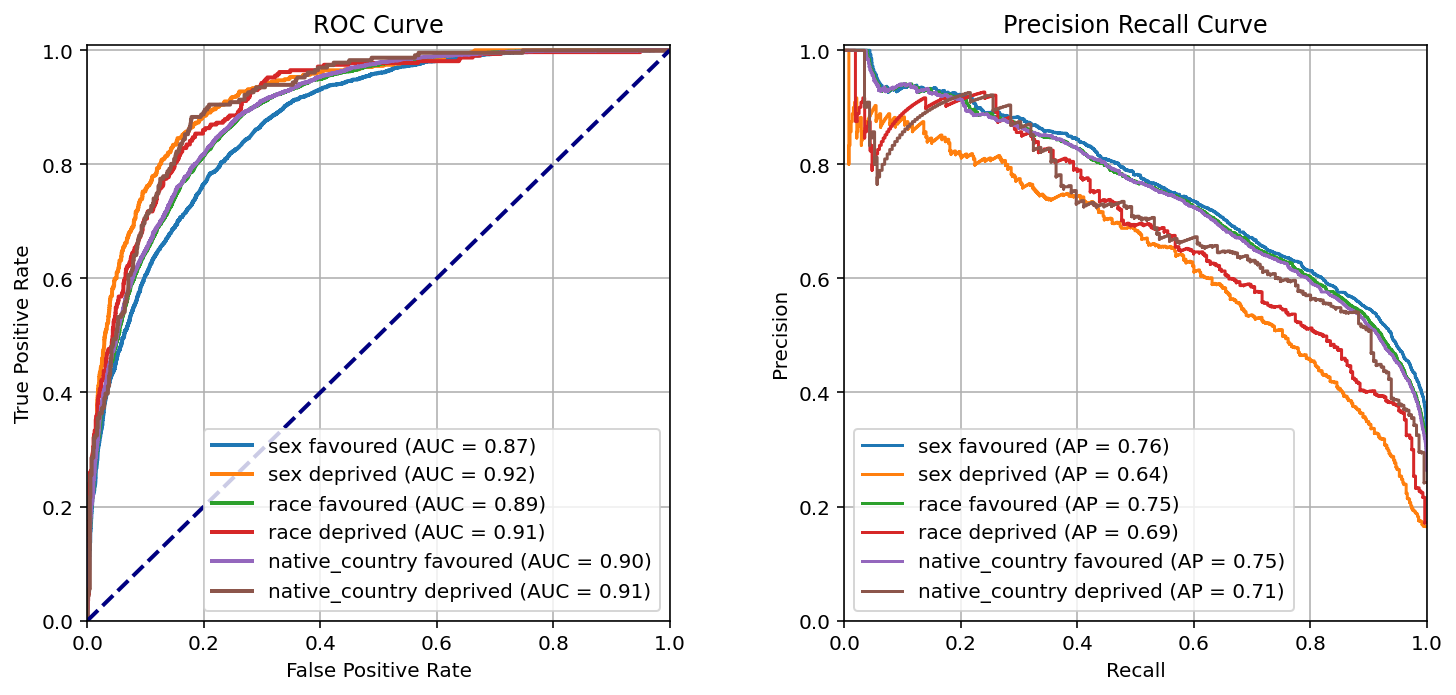

In [ ]:
X, y = encode_and_scale(data.drop(['salary'], axis=1)), data['salary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
clf_naive = train(X_train, y_train, X_test, y_test)
check_bias(clf_naive, X_test, y_test, ["sex", "race", "native_country"])

## 3.3.4 Unbiased split of the data into training and testing set

In [ ]:
data['demo_group'] = data['sex'].astype(str) + data['race'].astype(str) + data['salary'].astype(str)
data.demo_group.value_counts()

110    18214
010    10404
111     8733
100     2712
000     2596
011     1452
101      786
001      214
Name: demo_group, dtype: int64

In [ ]:
# Stratified split of dataset into train and test data w.r.t above demographic groups 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=data.demo_group)
del data['demo_group']

10 fold corss validation accuracy: 83.96%

                         sex            race           native_country 
                         value  biased  value  biased  value  biased
Statistical Parity Diff -0.157    True -0.071   False -0.027   False
Disparate Impact         0.292    True  0.608    True  0.846   False


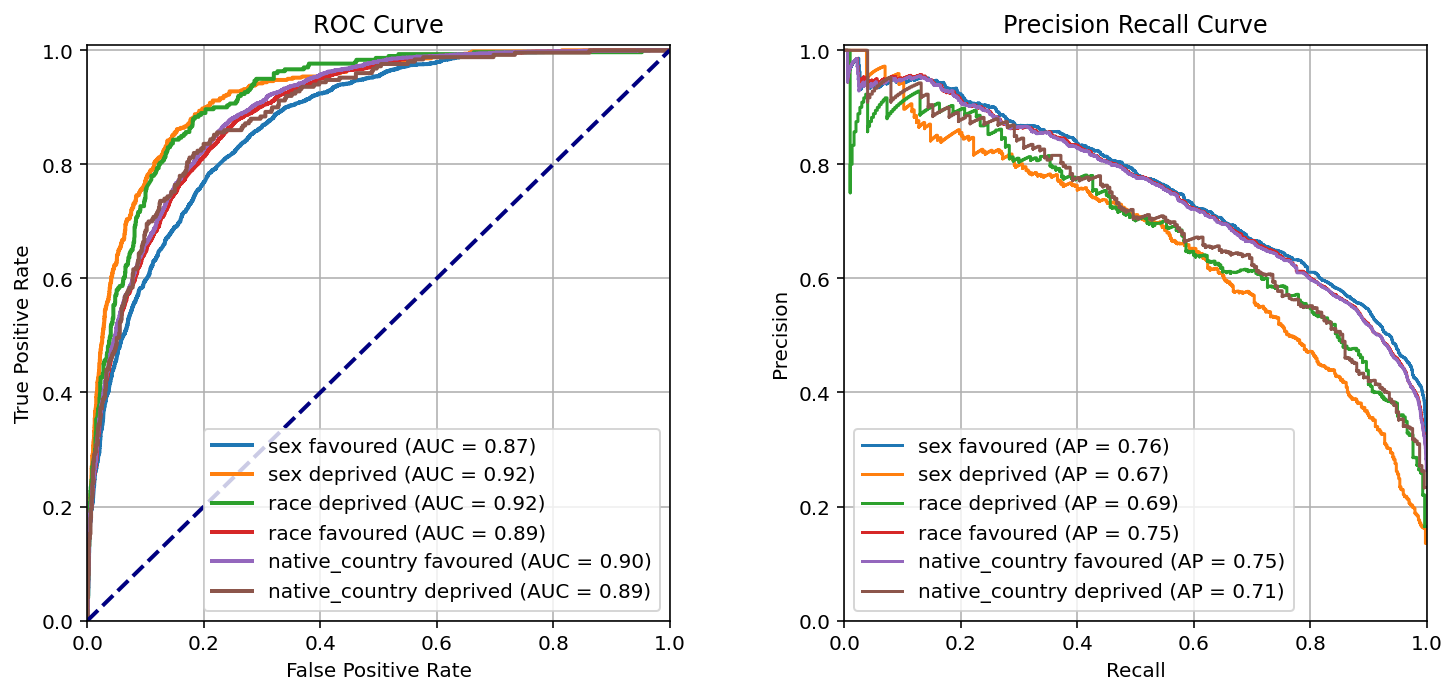

In [ ]:
clf_No = train(X_train, y_train, X_test, y_test)
check_bias(clf_No, X_test, y_test, ["sex", "race", "native_country"])

> `clf_No` will be used as the first trained baseline model

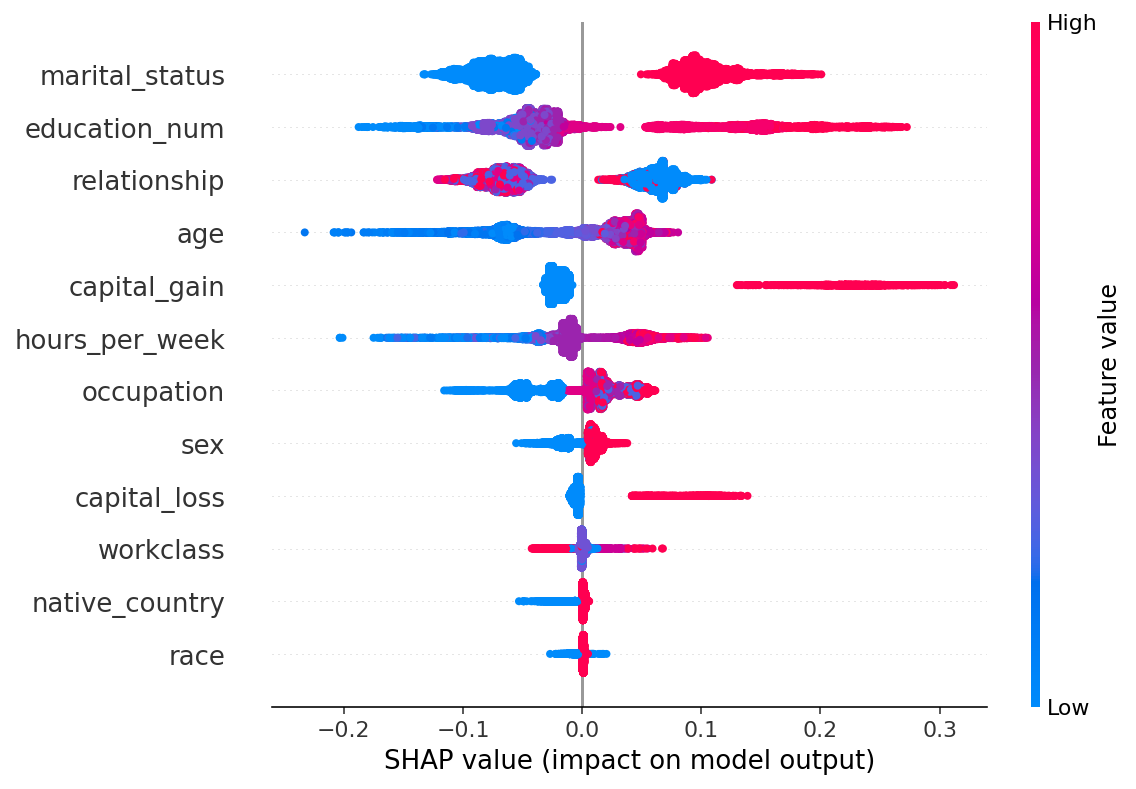

In [ ]:
shap_summery(clf_No, X_test)

# Task 3.4 Fair machine learning implementation

## Implementing Preferential Sampling

In [ ]:
from sklearn.naive_bayes import GaussianNB

def get_disp_impact(DP, FP, DN, FN):
    return (DP.shape[0]/(DP.shape[0] + DN.shape[0]))/(FP.shape[0]/(FP.shape[0] + FN.shape[0]))


def preferential_sample(df, feature, target, balance_value=0.8):
    X, y = encode_and_scale(df.drop([target], axis=1)), df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)
    R = GaussianNB()
    R.fit(X_train, y_train)
    print("Accuracy of ranker R:", R.score(X_test, y_test))
    df['prob'] = R.predict_proba(X)[:, 1]
    df['group'] = df[feature].map(lambda x: 'D' if x == 0 else 'F') +\
                  df[target].map(lambda x: 'N' if x == 0 else 'P')
    
    DP = df.query('group == "DP"').sort_values(by='prob')
    FP = df.query('group == "FP"').sort_values(by='prob')
    DN = df.query('group == "DN"').sort_values(by='prob', ascending=False)
    FN = df.query('group == "FN"').sort_values(by='prob', ascending=False)
    
    disp_val, i = get_disp_impact(DP, FP, DN, FN), 1
    while disp_val < balance_value:
        disp_val = get_disp_impact(pd.concat([DP, DP[:i]]), FP[i:], DN[i:], pd.concat([FN, FN[:i]]))
        i += 1
    
    del df['prob']
    del df['group']

    print(f"{i*2} values duplicated in DP and FN\n{i*2} values removed from the DN and FP")
    
    return pd.concat([pd.concat([DP, DP[:i]]), FP[i:], DN[i:], 
                      pd.concat([FN, FN[:i]])]).drop(['prob', 'group'], axis=1)

## Evaluating

10 fold corss validation accuracy: 83.97%

                         sex            race           
                         value  biased  value  biased
Statistical Parity Diff -0.159    True -0.075   False
Disparate Impact         0.290    True  0.587    True


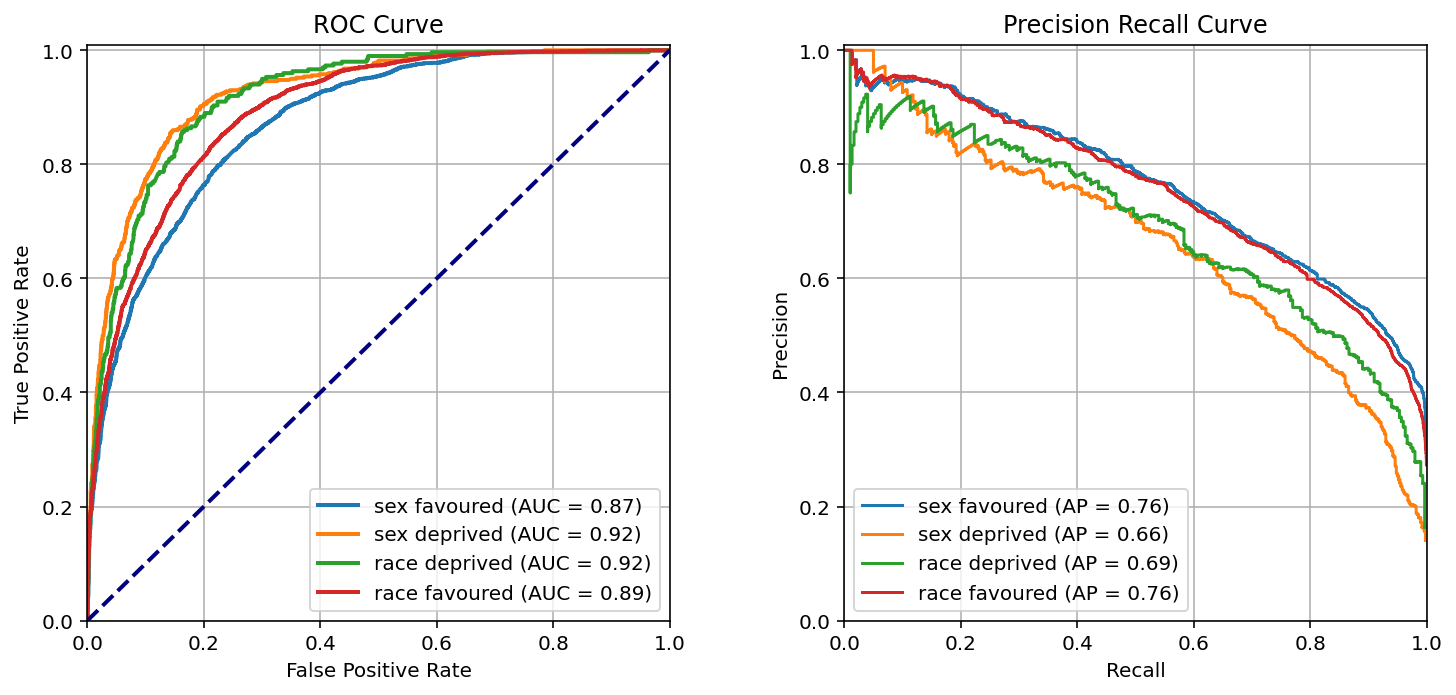

In [ ]:
# baseline 2 - train without sex attribute
clf_No_SA = train(X_train.drop(['sex'], axis=1), y_train, X_test.drop(['sex'], axis=1), y_test)
check_bias(clf_No_SA, X_test, y_test, ['sex', 'race'], exclude_cols=['sex'])

10 fold corss validation accuracy: 83.87%

                         sex            race           
                         value  biased  value  biased
Statistical Parity Diff -0.162    True -0.070   False
Disparate Impact         0.296    True  0.627    True


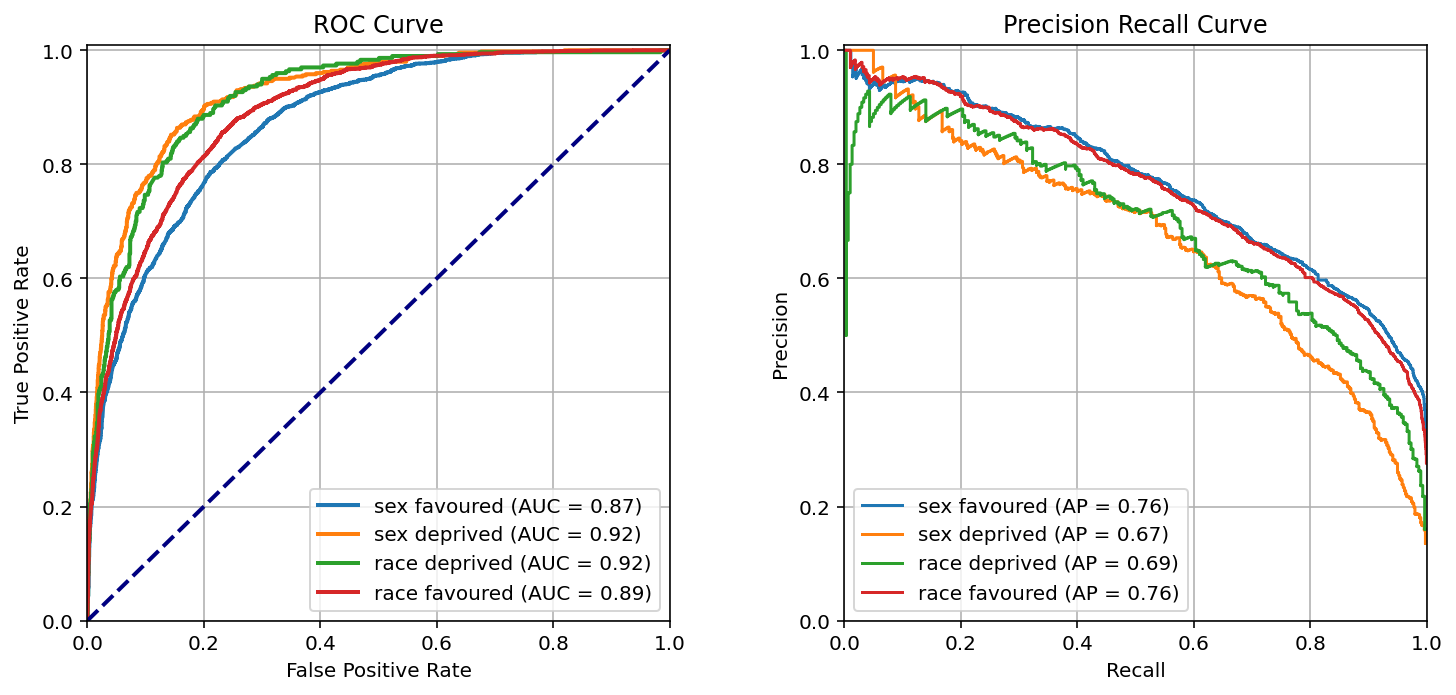

In [ ]:
# baseline 3 - train without race attribute
clf_No_RA = train(X_train.drop(['race'], axis=1), y_train, X_test.drop(['race'], axis=1), y_test)
check_bias(clf_No_RA, X_test, y_test, ['sex', 'race'], exclude_cols=['race'])

Accuracy of ranker R: 0.7891070297656745
464 values duplicated in DP and FN
464 values removed from the DN and FP
Accuracy of ranker R: 0.8034198860037999
1860 values duplicated in DP and FN
1860 values removed from the DN and FP
10 fold corss validation accuracy: 83.96%

                         sex            race           
                         value  biased  value  biased
Statistical Parity Diff -0.022   False -0.028   False
Disparate Impact         0.881   False  0.849   False


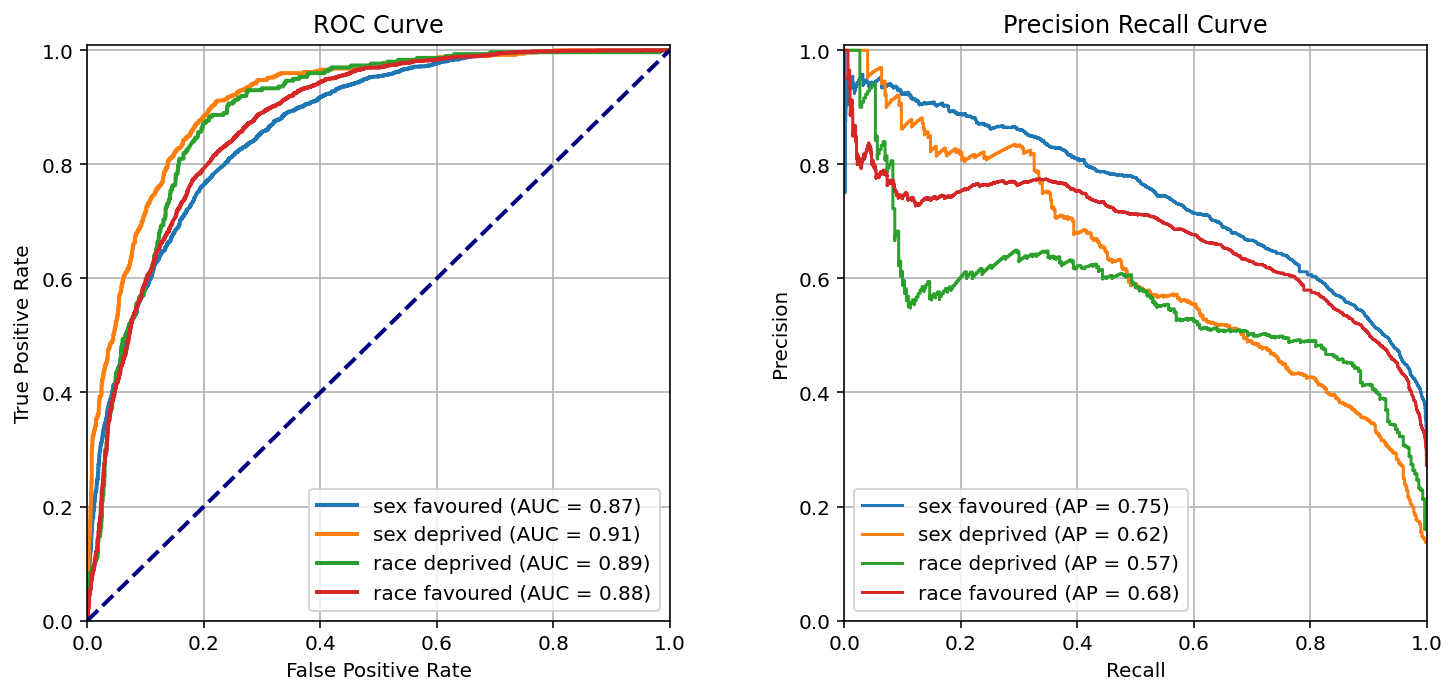

In [ ]:
# Preferentially resample test data
train_data = pd.concat([X_train, y_train], axis=1)
train_data = preferential_sample(train_data, 'race', 'salary', 0.83)
train_data = preferential_sample(train_data, 'sex', 'salary', 0.73)

# Model trained on dataset with resampled test data
X_train_ps, y_train_ps = encode_and_scale(train_data.drop(['salary'], axis=1)), train_data['salary']
clf_No_PS = train(X_train_ps, y_train_ps, X_test, y_test)
check_bias(clf_No_PS, X_test, y_test, ['sex', 'race'])